# Run Models on GPU

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xmaster6y/lczerolens/blob/main/docs/source/notebooks/features/run-models-on-gpu.ipynb)

## Setup

In [1]:
MODE = "local"  # "colab" | "colab-dev" | "local"

In [2]:
if MODE == "colab":
    !pip install -q lczerolens[hf]
elif MODE == "colab-dev":
    !rm -r lczerolens
    !git clone https://github.com/Xmaster6y/lczerolens -b main
    !pip install -q ./lczerolens --extra hf

## Load a Model

Load a leela network from file (already converted to `onnx`):

In [3]:
import torch
from lczerolens import LczeroModel

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


cpu_model = LczeroModel.from_hf("lczerolens/maia-1900")
gpu_model = LczeroModel.from_hf("lczerolens/maia-1900").to(device)

## Predict a Move

The defined model natively integrates with `python-cess`. Use the utils to predict a policy vector and obtain an UCI move:

In [4]:
import time

from lczerolens.board import LczeroBoard
from lczerolens.sampling import PolicySampler

board = LczeroBoard()

cpu_sampler = PolicySampler(cpu_model, use_argmax=True)
gpu_sampler = PolicySampler(gpu_model, use_argmax=True)

t0 = time.time()
next(iter(cpu_sampler.get_next_moves([board])))
print("CPU time:", time.time() - t0)

t0 = time.time()
next(iter(gpu_sampler.get_next_moves([board])))
print("GPU time:", time.time() - t0)

CPU time: 0.005054950714111328
GPU time: 4.454769849777222


In [5]:
def board_generator(N):
    for _ in range(N):
        yield LczeroBoard()


Ns = [10, 50, 100, 1000, 2000, 5_000, 10_000, 15_000, 20_000]
cpu_times = []
gpu_times = []

for N in Ns:
    t0 = time.time()
    next(iter(cpu_sampler.get_next_moves(board_generator(N))))
    cpu_times.append(time.time() - t0)
    t0 = time.time()
    next(iter(gpu_sampler.get_next_moves(board_generator(N))))
    gpu_times.append(time.time() - t0)

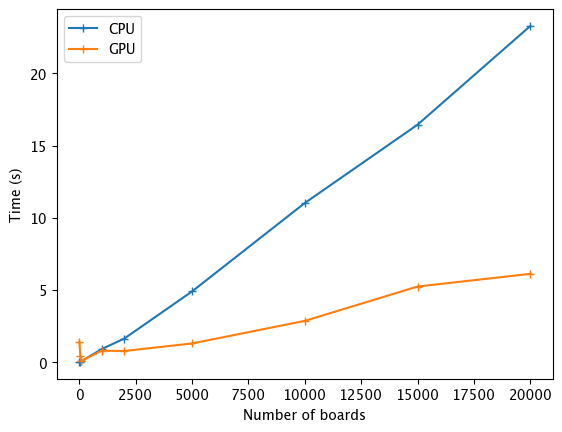

In [6]:
import matplotlib.pyplot as plt

plt.plot(Ns, cpu_times, label="CPU", marker="+")
plt.plot(Ns, gpu_times, label="GPU", marker="+")
plt.xlabel("Number of boards")
plt.ylabel("Time (s)")
plt.legend()
plt.show()